In [1]:
import pandas as pd
%matplotlib inline
import matplotlib as plt
pd.set_option("display.max_columns",999)
import numpy as np
import json

In [2]:
df_full=pd.read_pickle("../pickles/dataset_previo_final.pkl")

In [3]:
summary = pd.read_pickle("../pickles/originals_pickle.csv")

In [4]:
probabilities = pd.read_csv("../data/df_predicted_probs_originals.csv",)

In [6]:
probabilities.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'tweet_id', 'id', 'parent_id',
       'created_at', 'pais_clean', 'user_followers_count', 'retweet_count',
       'full_text', 'tweet_type', 'x', 'groups_linear', 'groups_circle',
       'y_cummulative', 'y_centrado', 'y', 'minute', 'pred_1a2a_persona',
       'pred_apoyo', 'pred_otros_trolls', 'pred_fisico', 'pred_no_fisico',
       'pred_otros'],
      dtype='object')

In [7]:
probabilities=probabilities[['id','pred_1a2a_persona','pred_apoyo','pred_otros_trolls','pred_fisico','pred_no_fisico','pred_otros']]
probabilities=probabilities[~probabilities.id.isna()]
probabilities.id= probabilities.id.astype(np.int)
probabilities = probabilities.set_index('id')

In [8]:
summary=summary.set_index('id')

In [10]:
prob_summary = summary.join(probabilities)

# Algunas graficas de las probabilidades

In [12]:
import ternary

In [13]:
points = [(x[1],x[2],x[3]) for x in probabilities.to_records()]

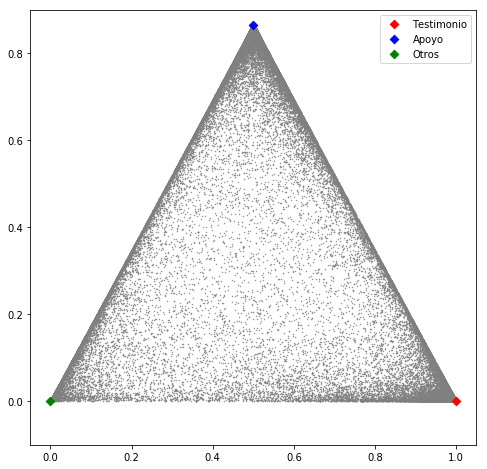

In [14]:
points = [(x[1],x[2],x[3]) for x in probabilities.to_records()]
figure, tax = ternary.figure()
figure.set_size_inches(8, 8)
tax.boundary(linewidth=0.01)
#tax.gridlines(multiple=5, color="blue")
tax.scatter(points, color='grey',s=0.2)
tax.scatter([(1,0,0)], marker='D', color='red', label="Testimonio")
tax.scatter([(0,1,0)], marker='D', color='blue', label="Apoyo")
tax.scatter([(0,0,1)], marker='D', color='green', label="Otros")
tax.legend()

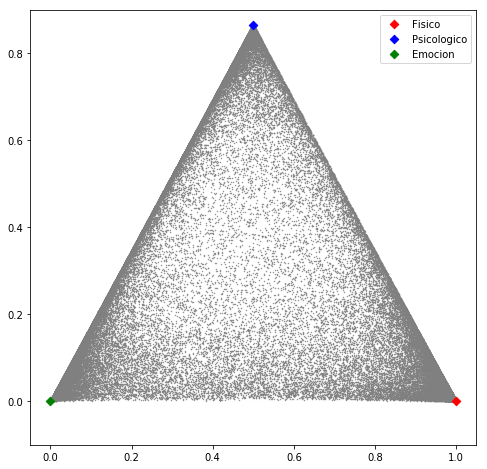

In [15]:
points = [(x[4],x[5],x[6]) for x in probabilities.to_records()]
figure, tax = ternary.figure()
figure.set_size_inches(8, 8)
tax.boundary(linewidth=0.01)
#tax.gridlines(multiple=5, color="blue")
tax.scatter(points, color='grey',s=0.2)
tax.scatter([(1,0,0)], marker='D', color='red', label="Fisico")
tax.scatter([(0,1,0)], marker='D', color='blue', label="Psicologico")
tax.scatter([(0,0,1)], marker='D', color='green', label="Emocion")
tax.legend()

# Calculo de coordenadas: CEBOLLA

In [17]:
import math

In [83]:
prob_summary.columns

Index(['parent_id', 'created_at', 'pais_clean', 'user_followers_count',
       'retweet_count', 'full_text', 'tweet_type', 'x', 'groups_linear',
       'groups_circle', 'y_cummulative', 'y_centrado', 'y', 'minute',
       'pred_1a2a_persona', 'pred_apoyo', 'pred_otros_trolls', 'pred_fisico',
       'pred_no_fisico', 'pred_otros', 'angle', 'radius'],
      dtype='object')

In [84]:
# FILTRAMOS LOS TWEETS RAROS
THRESHOLD_TROLLS =.75 #arriba de esto son tweets raros
prob_summary=prob_summary[prob_summary['pred_otros_trolls']<0.75]

In [87]:
def abc_to_rgb(A=0.0,B=0.0,C=0.0):
    ''' Map values A, B, C (all in domain [0,1]) to
    suitable red, green, blue values.'''
    return (min(B+C,1.0),min(A+C,1.0),min(A+B,1.0))

In [100]:
fu1 = plt.colors.LinearSegmentedColormap('hola',{'red':   ((0.0,  0.0, 0.0),(1.0,  1.0, 1.0)),
         'green': ((0.0,  1.0, 1.0),
                   (1.0, 0.0, 0.0)),
          'blue': ((0.0,  0.0, 0.0),
                   (1.0, 0.0, 0.0))})
def scale2(col):
    return  plt.colors.LinearSegmentedColormap('otr',{'red':   ((0.0,  0.0, 0.0),
                                                                (1.0,  col[0], col[0])),
         'green': ((0.0,  0.0, 0.0),
                   (1.0, col[1], col[1])),
          'blue': ((0.0,  0.0, 0.0),
                   (1.0, col[2], col[2]))})

In [102]:
fuA = scale2(fu1(0.3))

In [103]:
fuA(0.5)

(0.14960399846212993, 0.3523567858515955, 0.0, 1.0)

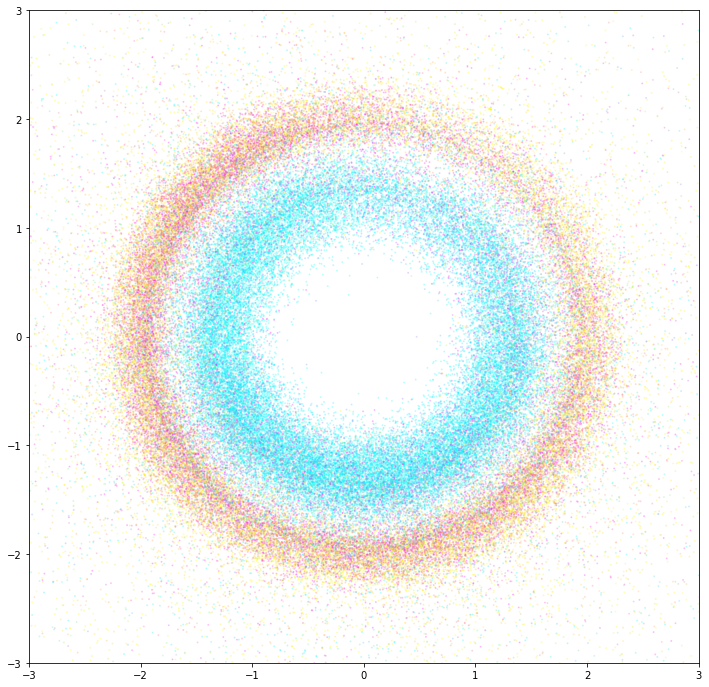

In [154]:
#angle 
ANGLE_NOISE = 1 #in degrees
prob_summary['angle']=math.pi/2-2*math.pi*prob_summary.groups_circle/1440+ANGLE_NOISE*np.random.randn(len(prob_summary))/360

#radius
INTERNAL_RADIUS = 0.7
BLUR_TESTIMONIOS = 0.2
THRESHOLD_BLUR_TESTIMONIO = 0.95
BLUR_APOYO = 0.2
THRESHOLD_BLUR_APOYO = 0.95
SCALE_APOYO = 0.7 
SCALE_OTROS = 2
PUSH_OTROS = 2
testimonio = BLUR_TESTIMONIOS*np.random.randn(len(prob_summary)) *( np.where(prob_summary['pred_1a2a_persona']>THRESHOLD_BLUR_TESTIMONIO,prob_summary['pred_1a2a_persona'],0))
# th: 0.5 y blur=0.3
# BLUR_TESTIMONIOS*np.random.randn(len(prob_summary)) *( (1+THRESHOLD_BLUR_TESTIMONIO)-prob_summary['pred_1a2a_persona'] )+ 
apoyo = SCALE_APOYO*(prob_summary['pred_apoyo']+BLUR_APOYO*np.random.randn(len(prob_summary))*( np.where(prob_summary['pred_apoyo']>THRESHOLD_BLUR_APOYO,prob_summary['pred_apoyo'],0)))
otros = SCALE_OTROS*np.exp(PUSH_OTROS*prob_summary['pred_otros_trolls'])
prob_summary['radius'] = testimonio +  apoyo +  otros  -INTERNAL_RADIUS

colores = [ abc_to_rgb(a,b,c)   for a,b,c in zip(prob_summary.pred_fisico, prob_summary.pred_no_fisico, prob_summary.pred_otros)]

plt.pyplot.figure(figsize=(12,12))
plt.pyplot.scatter(x=prob_summary.radius*np.cos(prob_summary.angle),c=colores,
                   y=prob_summary.radius*np.sin(prob_summary.angle),
                   s=1,alpha = 0.2)
plt.pyplot.xlim((-3,3))
plt.pyplot.ylim((-3,3))
plt.pyplot.show()

In [142]:
from datetime import timedelta
# from here https://en.wikipedia.org/wiki/List_of_time_zones_by_country
avg_tz_delta = {'España': 1,
  'Argentina': -3,
  'Colombia': -5,
  'México': -6,
  'Chile': -4,
  'Estados Unidos': -6.5,
  'Perú': -5,
  'Venezuela': -4,
  'Uruguay': -3,
  'Costa Rica': -6,
  'Ecuador': -5,
  'Puerto Rico': -4,
  'Reino Unido': 0,
  'Panamá': -5,
  'Brasil': -3,
  'Guatemala': -6,
  'Paraguay': -4,
  'Francia': 1,
  'El Salvador': -6,
  'Filipinas': 8,
  'Alemania': 1,
  'Italia': 1,
  'Cuba': -5,
  'Irlanda': 0,
  'Países Bajos': 1,
  'Honduras': -6,
  'Australia': 9,
  'Canadá': -6,
  'Nicaragua': -6,
  'Japón': 9,
  'Portugal': 0,
  'Rusia': 3,
  'Suiza': 1,
  'San Martín': -4,
  'Bolivia': -4,
  'Nigeria': -6,
  'India': 5.5,
  'Bélgica': 1,
  'Turquía': 3,
  'República Dominicana': -4,
  'Noruega': 1,
  'Grecia': 1,
  'Nueva Zelanda': 12,
  'Marruecos': 1,
  'Polonia': 1,
  'Suecia': 1,
  'Finlandia': 1,
  'Jamaica': -5,
  'Jersey': 0,
  'Corea del Sur': 9,
  'Sudáfrica': 2,
  'Andorra': 1,
  'Islandia': 0,
  'Rumania': 1,
  'Bangladés': 6,
  'Austria': 1,
  'Santa Lucía': -4,
  'Hong Kong': 8,
  'Indonesia': 7,
  'Egipto': 1,
  'Maldivas': 5,
  'Luxemburgo': 1,
  'Arabia Saudita': 3,
  'Palestina': 3
    }

In [145]:
def hora_local(row):
    hora_utc = row.created_at
    pais = row.pais_clean
    if pais in avg_tz_delta:
        delta = timedelta(0,3600*avg_tz_delta[pais])
        return hora_utc + delta
    else:
        return hora_utc

In [149]:
prob_summary['hora_local'] = prob_summary.apply(hora_local,axis=1)

In [151]:
prob_summary[['created_at','hora_local','pais_clean']]

,created_at,hora_local,pais_clean
id,,,
989762675411378177,2018-04-27 07:06:25,2018-04-27 08:06:25,España
989766305610743811,2018-04-27 07:20:50,2018-04-27 07:20:50,NaN
989784142069067776,2018-04-27 08:31:43,2018-04-27 09:31:43,España
989801589853577216,2018-04-27 09:41:03,2018-04-27 10:41:03,España
989803305340633089,2018-04-27 09:47:52,2018-04-27 09:47:52,NaN
989805361963073537,2018-04-27 09:56:02,2018-04-27 10:56:02,España
989806217982816257,2018-04-27 09:59:26,2018-04-27 10:59:26,España
989806975847424002,2018-04-27 10:02:27,2018-04-27 11:02:27,España
989807036811669505,2018-04-27 10:02:41,2018-04-27 10:02:41,NaN
